In [1]:
from IPython.display import display, HTML
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import wilcoxon, mannwhitneyu, ks_2samp

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB 
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy.stats import pearsonr

# decision trees
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
import numpy as np
import io, os , sys, types
import copy

import seaborn as sns
sns.set(color_codes=True)

# importing custom notebooks here
import import_ipynb as imppy
sys.meta_path.append(imppy.NotebookFinder())
from analytics_functions import *
from starcon_functions import *
from helper_functions import *
# import starcon_functions

# print in a tabulated pretty manner
from tabulate import tabulate

importing Jupyter notebook from analytics_functions.ipynb
importing Jupyter notebook from starcon_functions.ipynb


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
cwd = os.getcwd()
fname_raw = r'dataset\PlanetDatabase.csv'
data_raw = pd.read_csv(fname_raw)
data_raw = data_raw[data_raw.Cluster != 'Sol']  # Removing Sol system, since it is irrelevant
data_raw.reset_index(inplace=True, drop=True)
# data_raw = data_raw.iloc[:,1:].copy(deep=True)
fontsz = 14
DEBUG = False

data_features_calc = data_raw.copy(deep=True)  # operations to produce more features. Subset of these will be used in the model

In [4]:
col_class = 'MinValue' # Target to predict. Map this column to low, high [0, 1]
cols_numeric = ['DistFromStar']

data_class = data_features_calc[col_class]
data_class_mapped = resource_to_discrete_value(data_class, 450)

def createStarSystemKey(df, col_star, col_cluster):
    """Create a unique system key: Alpha_Centauri, Beta_Brahe, etc."""
    return df[col_star]+'_'+df[col_cluster]

data_features_calc['System'] = createStarSystemKey(data_features_calc, 'Star', 'Cluster')

data_features_calc=pd.concat([data_features_calc,
                              calc_PlanetNumber_and_isMoon(data_raw,'Planet',['PlanetNumber','isMoon'])], axis=1)

data_features_calc = calc_System_Thermal_Mean(data_features_calc)  # creates 'ThermalMean'

"""Convert categorical to dummy variables"""
cols_categoric = ['StarColor', 'StarSize']
data_dummies = dummify_variables(data_features_calc[cols_categoric])

Number of columns before dummy-variables:	2
Number of columns after dummy-variables:	9


In [11]:
# WRITING FEATURES AND CLASS TO FILE
# THIS IS THE INPUT FOR SUBSEQUENT CLASSIFIERS TO WORK ON
# --------------------------------------------------------------
fname_out = r'dataset/sc2features.csv'
cols_to_write = ['DistFromStar', 'PlanetNumber', 'isMoon', 'ThermalMean']
data_final = pd.concat([data_dummies, data_features_calc[cols_to_write]], axis=1)
data_final['class'] = data_class_mapped
data_final.to_csv(fname_out, index=False)

In [22]:
cols_features = set(data_final.columns.values)
cols_features.discard('class')
cols_features=list(cols_features)

In [23]:
cols_features

['StarColor_orange',
 'StarColor_red',
 'StarColor_blue',
 'DistFromStar',
 'StarColor_green',
 'isMoon',
 'StarSize_giant',
 'StarColor_yellow',
 'StarColor_white',
 'ThermalMean',
 'PlanetNumber',
 'StarSize_dwarf',
 'StarSize_super giant']

In [25]:
"""Create train and test sets"""
x_train, y_train, x_test, y_test = train_test_datasets(data_final[cols_features], data_final['class'], 0.6, 1013)

### Decision Tree

In [38]:
cols_features = x_train.columns.values

md = 6                    # maximum tree depth
mf = len(cols_features)    # maximum number of features to consider
min_leaf = 10
criterion = 'entropy'
model = tree.DecisionTreeClassifier(max_depth=md, max_features=mf, criterion=criterion, 
                                    min_samples_leaf=min_leaf, random_state=1984
                                   ,class_weight={0.0: 0.3, 1.0: 0.70})

clf = model.fit(x_train, y_train)
predicted = model.predict(x_test)
predicted_prob = model.predict_proba(x_test)[:, 1]

In [39]:
importance = model.feature_importances_
df_importance = pd.DataFrame(data=importance, index=cols_features, columns=['importance'])
df_importance = df_importance[df_importance['importance'] != 0]
# sort by feature importance
df_importance = df_importance.reindex(df_importance['importance'].abs().sort_values(ascending=False).index)
display(df_importance)

# Visualize the tree
write_Tree('dataset', clf, x_train.columns.values) 

,importance
ThermalMean,0.382288
DistFromStar,0.240309
StarColor_white,0.106960
StarColor_blue,0.083053
StarColor_green,0.082631
PlanetNumber,0.039824
StarColor_yellow,0.038585
isMoon,0.026350


Area-Under-Curve: 0.7125


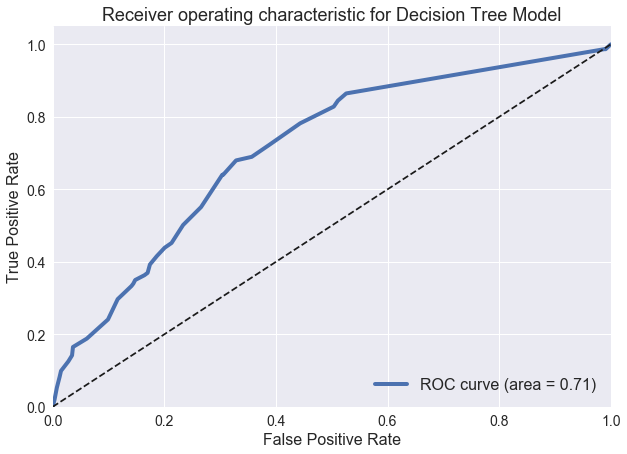

In [40]:
fpr, tpr, _ = metrics.roc_curve(np.array(y_test), predicted_prob)
auc = metrics.auc(fpr,tpr)
print ("Area-Under-Curve:", round(auc,4))
plot_ROC(fpr,tpr, fontsz, "Receiver operating characteristic for Decision Tree Model") 

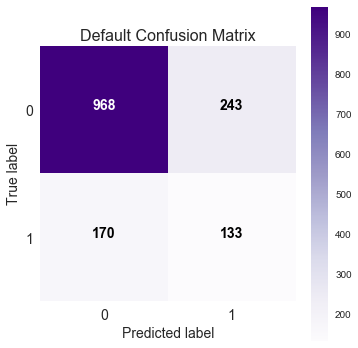

In [41]:
def_cfm = metrics.confusion_matrix(y_test, predicted) 
plot_confusion_matrix(def_cfm,['bad', 'good'], "Default Confusion Matrix", 0)

### Naive Bayes

In [31]:
gnb = BernoulliNB()
model = gnb.fit(x_train, y_train)
predicted = model.predict(x_test)
predicted_prob = model.predict_proba(x_test)[:, 1]

model_coefficients = model.coef_[0]
df_coeffs = pd.DataFrame(data=model_coefficients, index=cols_features, columns=['coeff'])
# sort by coefficients absolute value
df_coeffs = df_coeffs.reindex(df_coeffs['coeff'].abs().sort_values(ascending=False).index)
display(df_coeffs)

,coeff
StarSize_super giant,-3.352095
StarColor_orange,-2.569335
StarSize_giant,-2.541164
StarColor_yellow,-2.411111
StarColor_red,-2.411111
StarColor_green,-1.480292
StarColor_white,-1.362509
StarColor_blue,-1.312499
isMoon,-0.867188
StarSize_dwarf,-0.118330


Area-Under-Curve: 0.7404


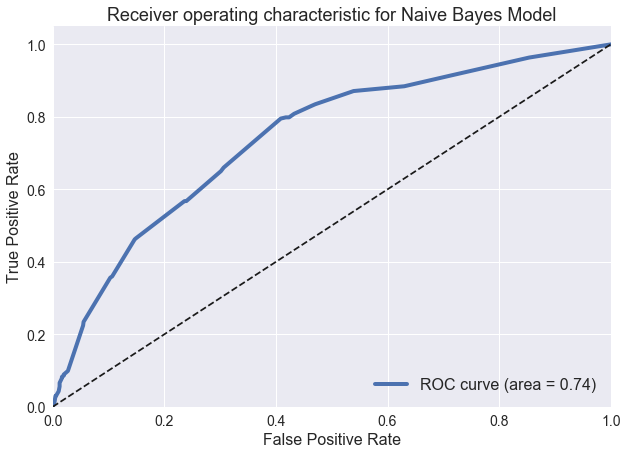

In [32]:
fpr, tpr, _ = metrics.roc_curve(np.array(y_test), predicted_prob)
auc = metrics.auc(fpr,tpr)
print ("Area-Under-Curve:", round(auc,4))
plot_ROC(fpr,tpr, fontsz, 'Receiver operating characteristic for Naive Bayes Model') 

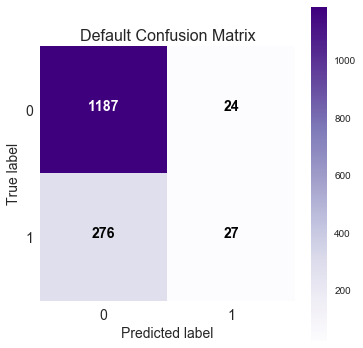

In [33]:
def_cfm = metrics.confusion_matrix(y_test, predicted) 
plot_confusion_matrix(def_cfm,['bad', 'good'], "Default Confusion Matrix", 0)